In [1]:
import xml.etree.ElementTree
import os,glob,sys
import pandas as pd
from sklearn.decomposition import PCA
import pylab as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2

sys.path.append("..")
from mzmine import pick_peaks, align, match_aligned_to_original, load_aligned_peaks


In [2]:
MZMINE_COMMAND = '/Users/anamaria/Documents/git/MZmine-2.40.1/startMZmine_MacOSX.command'

In [3]:
MNET_PATH = '/Users/anamaria/Documents/git/molnet/code/'

## Peak detection using MZmine

At the moment, this part is performed directly in MZmine.

In [ ]:
#for patients
# Directory holding mzml files of interest
input_dir = '/Volumes/Transcend/Metabolomics_datasets/Zika/Positive/Control'
# grab the list -- in this case all the T10 mzML files
file_list = glob.glob(os.path.join(input_dir,'**.mzXML'))

# # Directory to store all output
output_dir = '/Volumes/Transcend/Metabolomics_datasets/Zika/mzmine'

In [ ]:
from mzmine import pick_peaks
pick_peaks(file_list,output_dir=output_dir, xml_template = '/Users/anamaria/Desktop/mzmine/peak_picking_to_mztab_csv.xml', mzmine_command=MZMINE_COMMAND)

## Alignment

In [87]:
allfiles = '/Users/anamaria/Desktop/mzmine/221119/vl'

In [88]:
allfiles

'/Users/anamaria/Desktop/mzmine/221119/vl'

In [4]:
xml_template ='/Users/anamaria/Documents/git/pymzmine/batch_files/align_from_mztab.xml'
align(allfiles, xml_template = xml_template, mzmine_command = MZMINE_COMMAND, rt_window = 0.5)


['/Users/anamaria/Desktop/mzmine/221119/zik/ZIK10_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/ZIK7_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/ZIK6_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/C1_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/ZIK1_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/C7_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/C6_r_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/C2_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/C3_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/C9_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/ZIK4_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/ZIK5_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/C5_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/C4_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/ZIK9_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/ZIK8_pp.mzTab', '/Users/anamaria/Desktop/mzmine/221119/zik/ZIK3_pp.mzTab', '/Users/a

If files already aligned.

In [64]:
aligned_file = '/Users/anamaria/Documents/pymz/mzmine/221119/vl/pp_aligned.csv'

In [65]:
all_df = pd.read_csv(aligned_file, index_col=0)
feature_description = all_df.iloc[:,:2]
all_samples = all_df.iloc[:,2:-1]
all_samples.columns = [x.split(" ")[0] for x in list(all_samples.columns)]

In [66]:
condition = []
dataset = []
for name in np.array(all_samples.columns):
    value = name.split('.')[0].split('_')[0][0]
    value2 = name.split('.')[0].split('_')[0][0]
    
    if (value == 'C' and len(name.split('.')[0].split('_')) == 2 and name.split('.')[0].split('_')[1] == '2'):
        condition.append('control')
        dataset.append('VL')
    elif  (value == 'C'):   
        condition.append('control')
        dataset.append('Zika')
    elif (value == 'Z'):
        condition.append('infected')
        dataset.append('Zika')
    elif (value[0] == 'V'):
        condition.append('infected')
        dataset.append('VL')
        
    elif (value == 'K' and int(name.split('.')[0].split('_')[1])%3 == 1 ):
        condition.append('control')
        dataset.append('Malaria')
    else:
        condition.append('infected')
        dataset.append('Malaria')
        

In [67]:
sample_description = pd.DataFrame(data=[list(all_samples.columns),condition,dataset] )
sample_description = sample_description.transpose()
sample_description.columns = ['Sample Name', 'Condition', 'Dataset']
sample_description["ConditionDataset"] = sample_description["Condition"]+sample_description["Dataset"]

In [68]:
all_samples_log = np.log2(all_samples+1)

In [69]:
len(all_samples_log)

27561

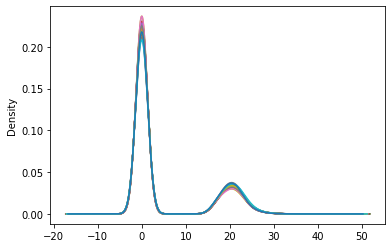

In [60]:
all_samples_log.plot.density(legend = False)

In [71]:
# rearranging the dataframe
Zik = all_samples_log.transpose()[np.array(sample_description['Dataset'] == 'VL')].transpose()
zik_con = Zik.transpose()[np.array(sample_description[sample_description["Dataset"] == "VL"]['Condition'] =="control")].transpose()
zik_inf = Zik.transpose()[np.array(sample_description[sample_description["Dataset"] == "VL"]['Condition'] =="infected")].transpose()


In [72]:
pdList = [zik_inf,zik_con]  
all_samples_log_rearanged = pd.concat(pdList, axis = 1)

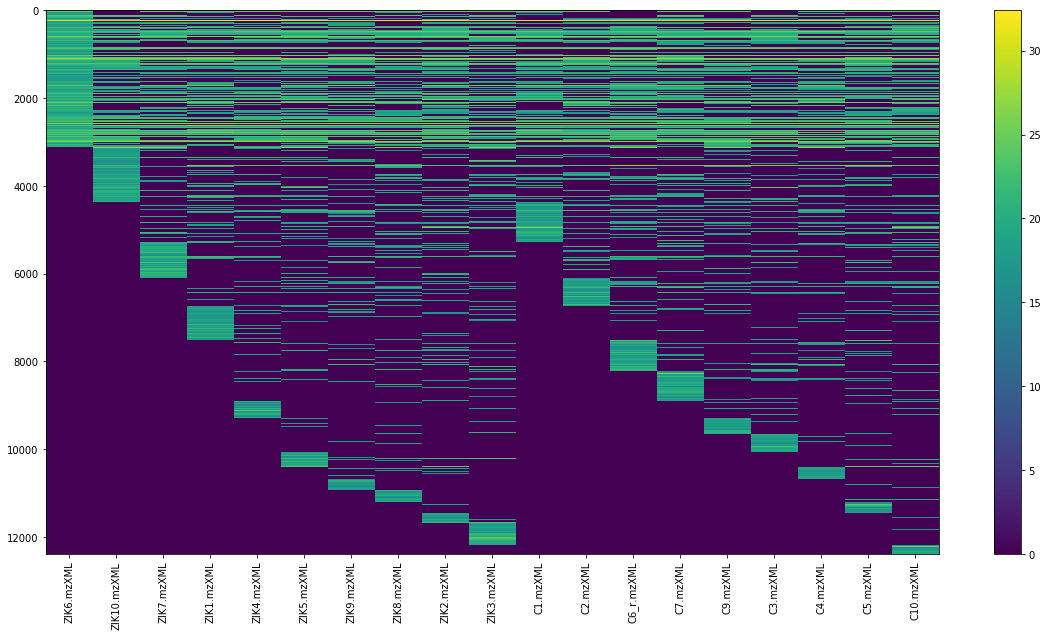

In [16]:
plt.figure(figsize=(10,5))
plt.imshow(all_samples_log_rearanged,aspect='auto')
plt.xticks(list(range(0,len(all_samples_log_rearanged.columns))), all_samples_log_rearanged.columns, rotation = 90)
plt.colorbar()
plt.show()


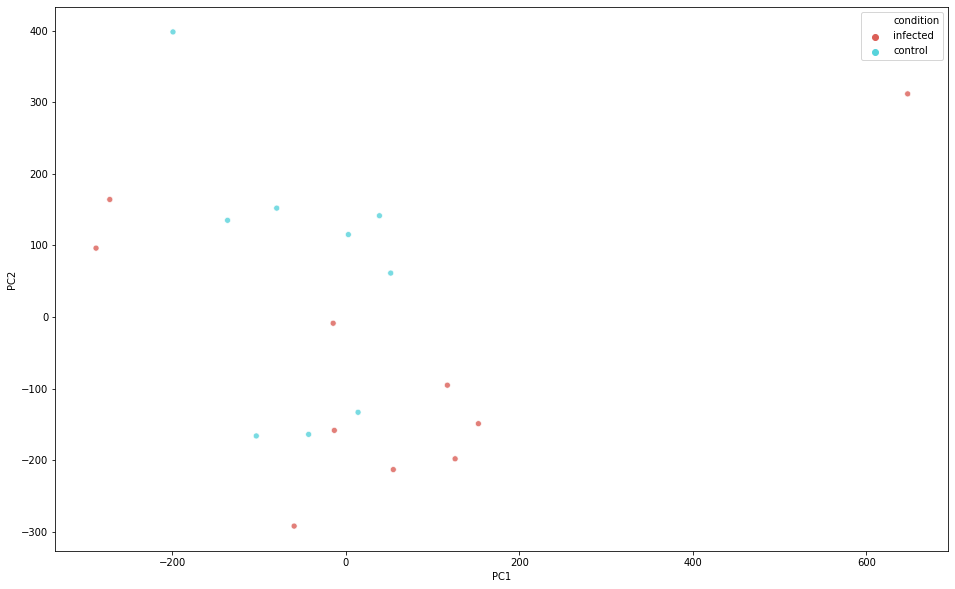

In [17]:
pca_samples = PCA(n_components=3)

principalComponents = pca_samples.fit_transform(all_samples_log.transpose())
principalComponents_df = pd.DataFrame(data = principalComponents, columns= ['PC1','PC2', 'PC3'])
principalComponents_df['condition'] = list(sample_description['Condition'])
principalComponents_df['dataset'] = list(sample_description['Dataset'])

plt.figure(figsize=(16,10))
sns.scatterplot(x="PC1", y="PC2",hue="condition",
    palette=sns.color_palette("hls", 2),
    data=principalComponents_df,
    legend="full",
    alpha=0.8
)

Filter data, so that 50% of the peaks are not 0s.


Skip this step for individual datasets.

In [73]:
def get_ids_for_50_percent(dataframe):
    idlist = []
    for rowid,row in dataframe.iterrows():
        total_zero = 0
        for i in range(len(row)):
            if row[i] == 0.0:
                total_zero += 1
        percentage = total_zero*100/len(row)
        if percentage <= 50:
            idlist.append(rowid)
    return np.array(idlist)

2392


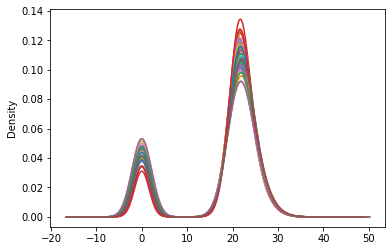

In [74]:
idzik = get_ids_for_50_percent(all_samples_log_rearanged[Zik.columns])
inters = set(idzik)
print(len(inters))
all_samples_log_filtered_50 = all_samples_log.loc[inters]
all_samples_log_filtered_50.plot.density(legend=False)

In [75]:
all_samples_log_filtered_na = all_samples_log_filtered_50.copy()
all_samples_log_filtered_na.replace(0, np.nan, inplace = True)

In [76]:
from fancyimpute import KNN
def impute_knn(zik_con):
    zik_con_filt = all_samples_log_filtered_50[zik_con.columns]
    zik_con_filt.replace(0, np.nan, inplace = True)
    zik_con_filled_knn = KNN(k=3).fit_transform(zik_con_filt)
    df = pd.DataFrame(zik_con_filled_knn, columns=zik_con_filt.columns, index = zik_con_filt.index)
    return df

In [77]:
zik_con_filled = impute_knn(zik_con)
zik_inf_filled = impute_knn(zik_inf)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


Imputing row 1/2392 with 0 missing, elapsed time: 1.505
Imputing row 101/2392 with 6 missing, elapsed time: 1.516
Imputing row 201/2392 with 0 missing, elapsed time: 1.526
Imputing row 301/2392 with 7 missing, elapsed time: 1.533
Imputing row 401/2392 with 2 missing, elapsed time: 1.543
Imputing row 501/2392 with 0 missing, elapsed time: 1.552
Imputing row 601/2392 with 1 missing, elapsed time: 1.560
Imputing row 701/2392 with 0 missing, elapsed time: 1.568
Imputing row 801/2392 with 0 missing, elapsed time: 1.575
Imputing row 901/2392 with 4 missing, elapsed time: 1.583
Imputing row 1001/2392 with 0 missing, elapsed time: 1.592
Imputing row 1101/2392 with 1 missing, elapsed time: 1.601
Imputing row 1201/2392 with 4 missing, elapsed time: 1.609
Imputing row 1301/2392 with 0 missing, elapsed time: 1.618
Imputing row 1401/2392 with 0 missing, elapsed time: 1.624
Imputing row 1501/2392 with 5 missing, elapsed time: 1.634
Imputing row 1601/2392 with 0 missing, elapsed time: 1.645
Imputing 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


Imputing row 1/2392 with 0 missing, elapsed time: 1.367
Imputing row 101/2392 with 1 missing, elapsed time: 1.381
Imputing row 201/2392 with 0 missing, elapsed time: 1.396
Imputing row 301/2392 with 7 missing, elapsed time: 1.413
Imputing row 401/2392 with 1 missing, elapsed time: 1.423
Imputing row 501/2392 with 0 missing, elapsed time: 1.435
Imputing row 601/2392 with 0 missing, elapsed time: 1.445
Imputing row 701/2392 with 0 missing, elapsed time: 1.456
Imputing row 801/2392 with 7 missing, elapsed time: 1.468
Imputing row 901/2392 with 11 missing, elapsed time: 1.494
Imputing row 1001/2392 with 0 missing, elapsed time: 1.515
Imputing row 1101/2392 with 9 missing, elapsed time: 1.536
Imputing row 1201/2392 with 6 missing, elapsed time: 1.561
Imputing row 1301/2392 with 3 missing, elapsed time: 1.584
Imputing row 1401/2392 with 0 missing, elapsed time: 1.609
Imputing row 1501/2392 with 8 missing, elapsed time: 1.647
Imputing row 1601/2392 with 0 missing, elapsed time: 1.680
Imputing

In [78]:
pdList = [zik_inf_filled,zik_con_filled]  
all_samples_log_filled = pd.concat(pdList, axis = 1)

In [79]:
all_samples_log_filled = all_samples_log_filled[all_samples_log_filtered_50.columns]

In [80]:
all_samples_log_filled

,C10_2.mzXML,C7_2.mzXML,VL7.mzXML,C18_2.mzXML,C2_2.mzXML,C12_2.mzXML,VL17.mzXML,VL16.mzXML,C5_2.mzXML,C8_2.mzXML,...,C1_2.mzXML,C16_2.mzXML,C4_2.mzXML,VL3.mzXML,C13_2.mzXML,VL13.mzXML,VL12.mzXML,C9_2.mzXML,VL18.mzXML,VL19.mzXML
row ID,,,,,,,,,,,,,,,,,,,,,
1,25.523555,25.352702,24.761446,25.436102,25.366297,25.106514,26.320643,25.836367,24.943663,24.581244,...,25.459625,25.370187,25.357845,25.591503,24.947534,25.268957,25.257022,25.742968,24.339035,25.515295
2,21.216704,21.338301,20.614700,21.093414,20.875614,20.073365,22.779836,22.177124,20.140776,20.478477,...,20.744719,20.831344,21.410454,22.208456,21.067011,21.095637,21.601864,20.809910,21.307513,20.829123
3,20.332473,21.104991,19.034914,21.607177,20.436288,20.893575,21.139317,20.906500,20.505261,20.646630,...,20.744383,21.064915,20.630643,20.989215,21.170852,18.587767,20.380351,21.267672,19.672596,21.172006
4,16.997642,18.276002,18.773472,19.317120,17.713118,18.320186,18.478894,17.957536,18.257040,18.430592,...,19.136453,19.161896,17.180884,18.120440,19.472957,16.697166,16.868158,18.153269,18.010550,19.067775
5,21.615177,20.969349,19.243759,20.873144,21.176372,22.243211,21.139030,21.127514,21.520550,22.006612,...,21.892883,20.632178,21.349044,20.601442,22.037353,20.345009,20.656912,21.923601,20.779725,19.892236
7,20.290524,20.132861,19.904322,19.074313,20.211624,19.569921,21.670083,18.575842,20.214132,20.000404,...,20.320364,19.937573,20.350684,19.166472,20.532023,22.251178,19.694693,20.536401,19.106849,21.550805
8200,19.513080,20.444031,21.831372,19.391998,19.398748,19.173010,22.274442,20.865005,19.002370,20.260152,...,19.935164,19.382469,19.381604,22.567388,20.966843,22.847182,24.046932,19.090523,20.826580,25.022232
13,20.262940,19.928483,21.509538,20.420045,20.076511,20.103239,21.449042,20.698654,19.817196,19.446056,...,20.537637,20.601345,21.000338,20.594494,19.855998,20.227314,20.441245,20.545589,20.587774,20.331842
14,20.441004,21.262070,20.235711,21.579752,20.717521,21.724157,19.512561,22.730033,21.096088,20.826300,...,21.989844,20.857435,21.667348,20.278470,21.794317,19.704529,19.657563,21.797606,19.970078,19.684187


## Limma analysis in R

In [75]:
all_samples_log.to_csv(r'/Users/anamaria/Documents/pymz/mzmine/221119/zik/all_samples_log2.csv', header=True, index=True, sep=',', mode='w')
sample_description.to_csv(r'/Users/anamaria/Documents/pymz/mzmine/221119/zik/sample_description.csv', header=True, index=None, sep=',', mode='w')

In [81]:
all_samples_log_filled.to_csv(r'/Users/anamaria/Documents/pymz/mzmine/221119/vl/all_samples_log2.csv', header=True, index=True, sep=',', mode='w')
sample_description.to_csv(r'/Users/anamaria/Documents/pymz/mzmine/221119/vl/sample_description.csv', header=True, index=None, sep=',', mode='w')

In [82]:
toptable = pd.read_csv("/Users/anamaria/Documents/pymz/mzmine/221119/Vl/limma_independent_toptable.csv", sep=',')

In [83]:
toptable[toptable['adj.P.Val'] < 0.05]

,logFC,AveExpr,t,P.Value,adj.P.Val,B
2976,-21.172086,11.174156,-285.325124,1.865279e-63,4.461747e-60,104.491027
200,-23.868662,12.597349,-221.421791,2.203843e-59,2.635796e-56,102.519858
2659,-21.284621,11.233550,-213.840754,7.991154e-59,6.371613e-56,102.183306
323,-21.066261,11.118305,-168.309881,5.576388e-55,3.334680e-52,99.361014
4183,-22.890044,12.080857,-152.432803,2.169744e-53,1.038006e-50,97.908518
4131,-22.219793,11.727113,-146.451417,9.520669e-53,3.795573e-50,97.271215
1827,-20.147488,10.633397,-141.424732,3.459117e-52,1.182030e-49,96.690968
3726,-22.793006,12.029642,-134.361183,2.295012e-51,6.862087e-49,95.798553
2161,-20.846076,11.002096,-131.082753,5.714190e-51,1.518705e-48,95.350683
2393,-22.767196,12.016020,-129.727521,8.387125e-51,2.006200e-48,95.158830


In [84]:
#limma_topfeatures = all_samples_log.loc[toptable.index]
limma_topfeatures = all_samples_log.loc[toptable.index]
limma_topfeatures = limma_topfeatures.transpose()
limma_topfeatures["Condition"] = np.array(sample_description["ConditionDataset"])

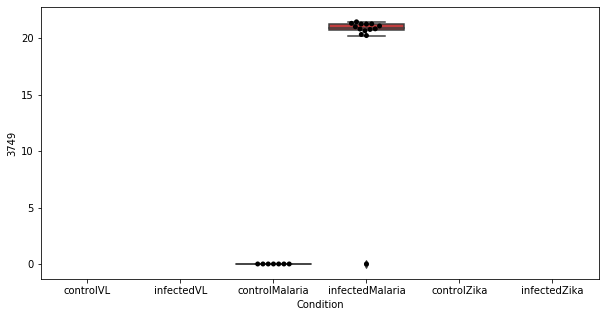

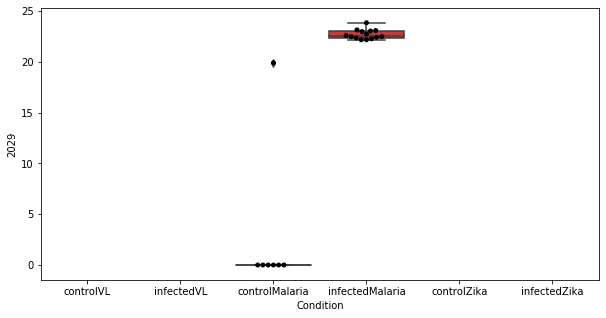

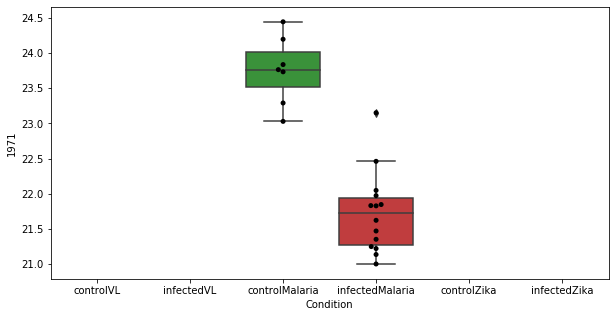

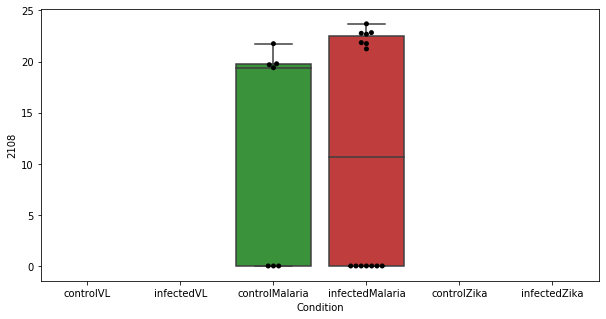

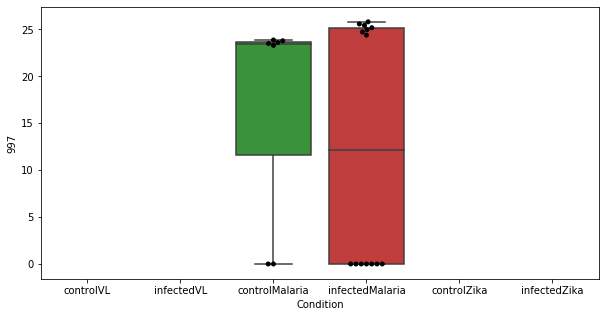

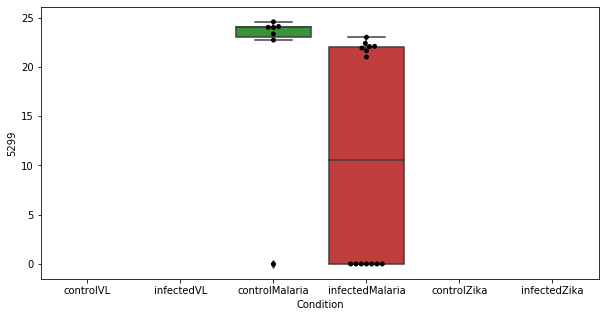

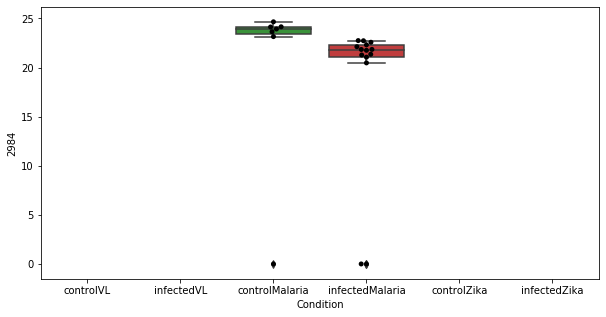

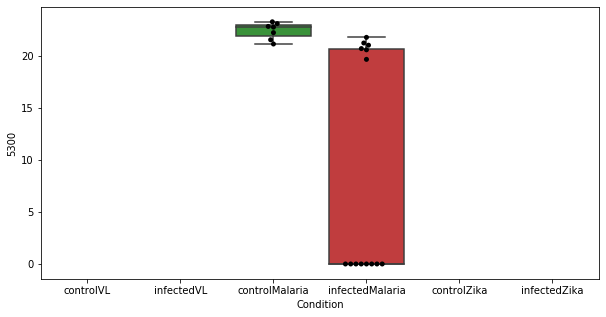

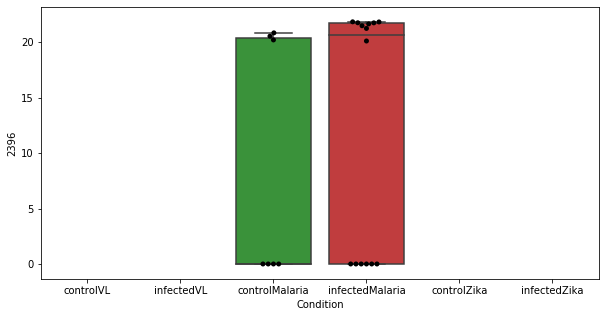

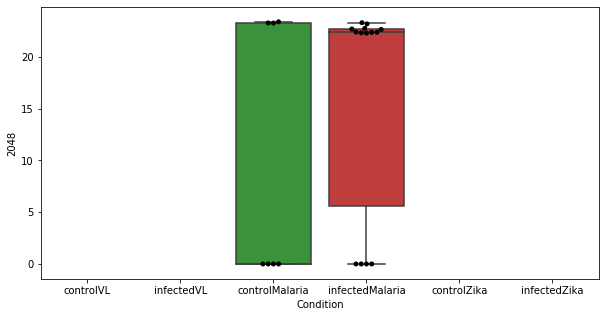

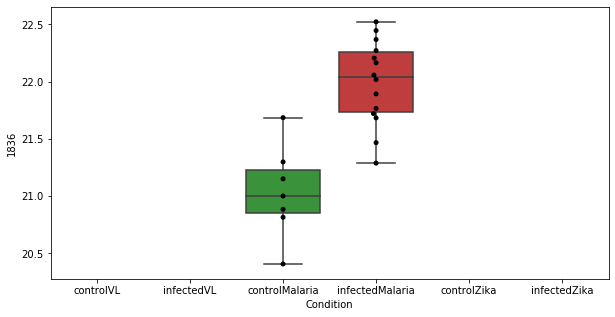

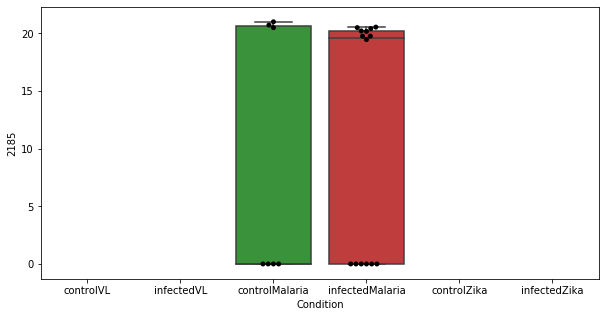

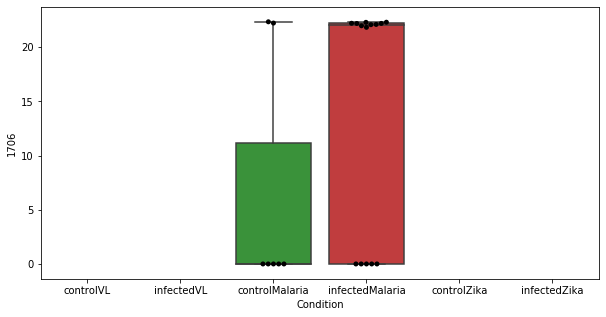

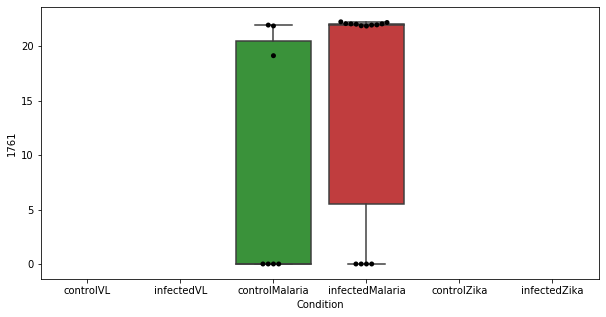

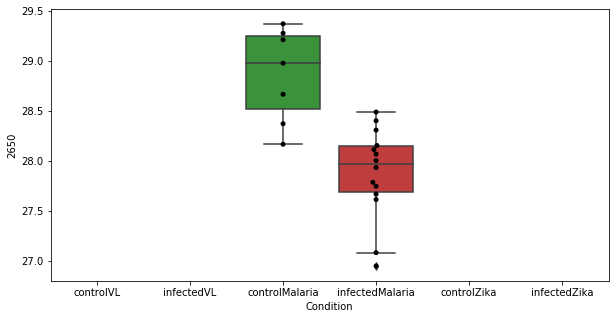

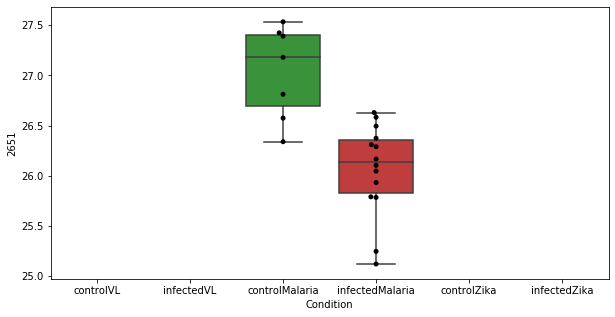

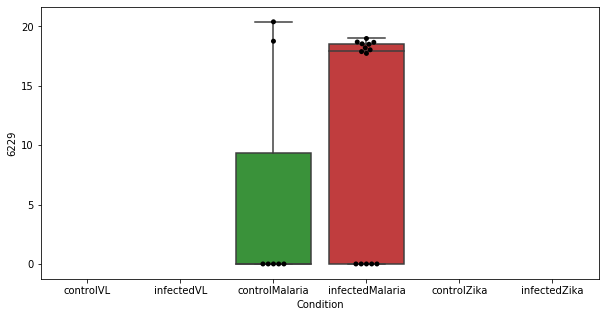

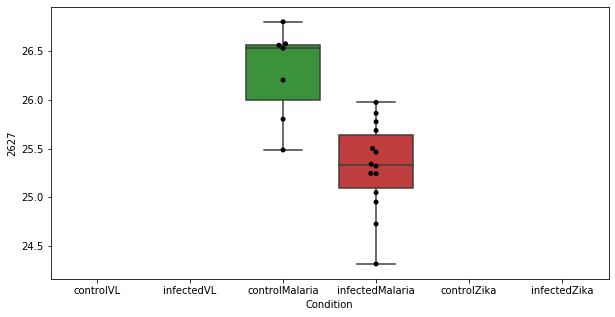

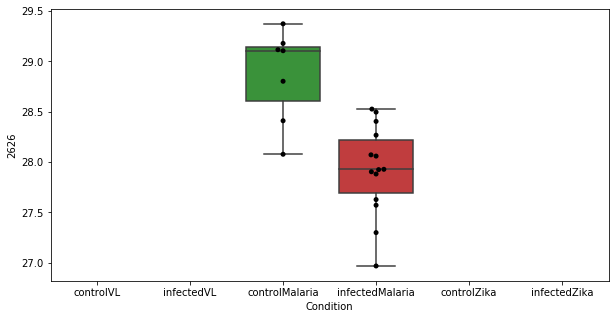

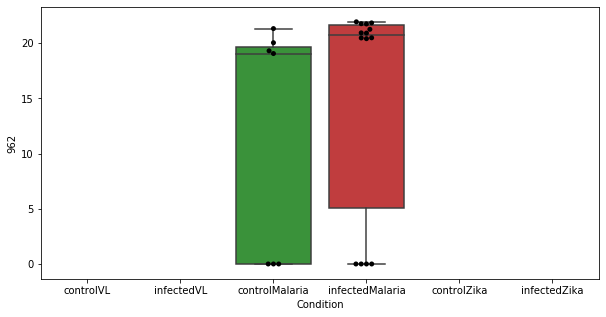

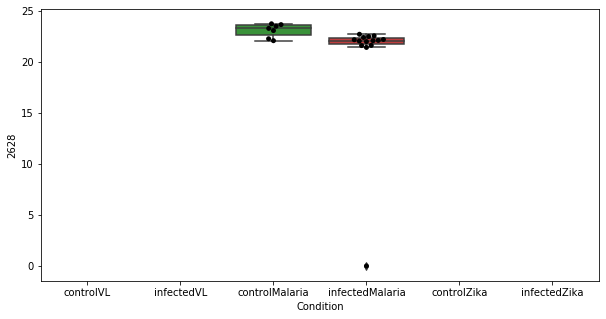

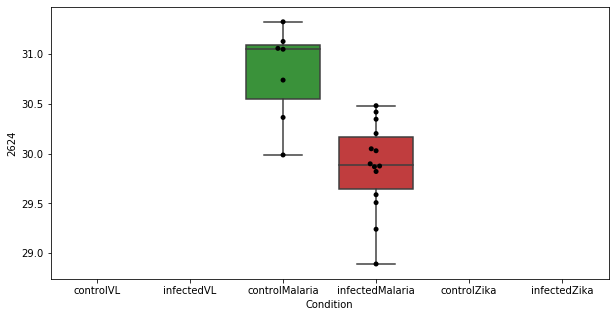

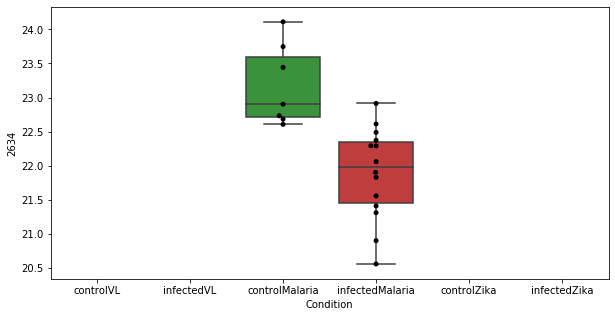

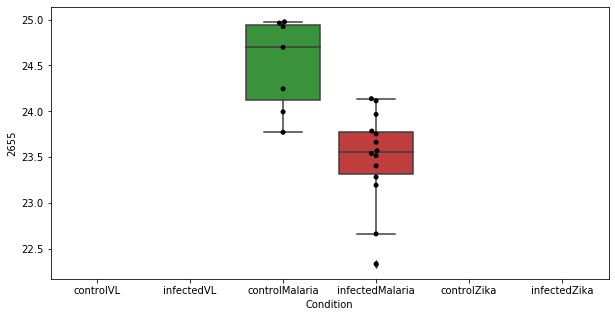

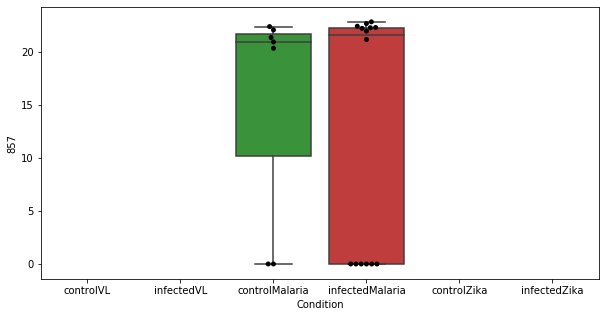

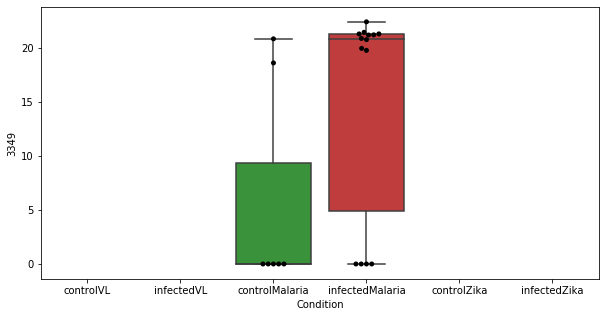

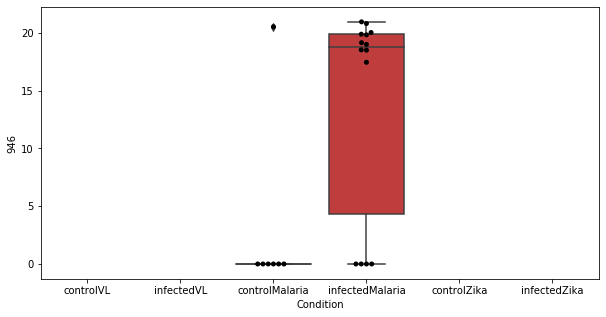

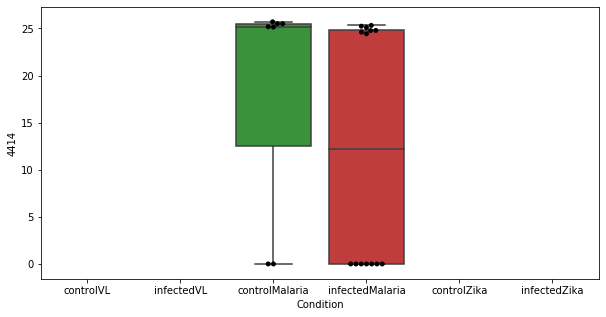

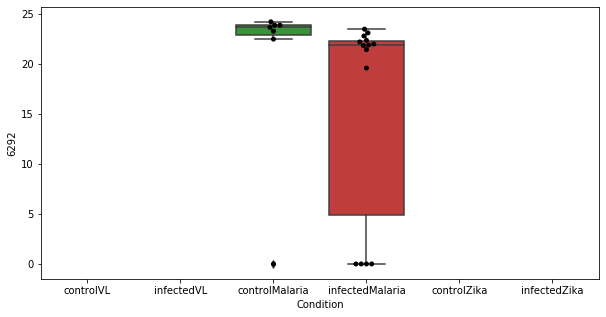

KeyboardInterrupt: 

In [59]:
for i in range(len(list(limma_topfeatures.columns))):
    plt.figure(figsize=(10,5))
    ax = sns.boxplot(y=list(limma_topfeatures.columns)[i], x="Condition", data = limma_topfeatures, order = ['controlVL','infectedVL','controlMalaria', 'infectedMalaria', 'controlZika','infectedZika'] )
    ax = sns.swarmplot(y=list(limma_topfeatures.columns)[i], x="Condition", data = limma_topfeatures, order = ['controlVL','infectedVL','controlMalaria', 'infectedMalaria', 'controlZika','infectedZika'], color="black")
    plt.show()

In [22]:
def plot_boxplots(limma_topfeatures, metab_id, ylim, y = False ):
    plt.figure(figsize=(10,5))
   
    ax = sns.boxplot(y=limma_topfeatures[metab_id], x="Condition", data = limma_topfeatures, order = ['controlVL','infectedVL','controlMalaria', 'infectedMalaria', 'controlZika','infectedZika'] )
    ax = sns.swarmplot(y=limma_topfeatures[metab_id], x="Condition", data = limma_topfeatures, order = ['controlVL','infectedVL','controlMalaria', 'infectedMalaria', 'controlZika','infectedZika'], color="black")
    if y:
        plt.ylim(ylim)
    plt.show()

## Preparing file for mummichog

In [85]:
data = feature_description.loc[toptable.index]
data['adj-p'] = toptable['adj.P.Val']
data['t-val'] = toptable['t']
data['custom_id'] = list(data.index)

In [61]:
#pd.set_option('display.max_rows', 1000)
data[data['adj-p'] <= 0.05]

,row m/z,row retention time,adj-p,t-val,custom_id
3749,228.032433,7.956263,5.439260e-30,141.065638,3749
2029,268.103810,8.254377,8.851000e-08,11.699449,2029
1971,258.109988,11.681582,3.497642e-05,-8.140901,1971
2108,276.157826,17.429803,1.494450e-04,7.268173,2108
997,166.032180,5.602246,1.494450e-04,7.196258,997
5299,1019.701799,4.083596,1.793857e-04,-7.026729,5299
2984,992.673950,4.124041,5.060552e-04,-6.485048,2984
5300,1020.704472,4.079428,6.572147e-04,-6.309140,5300
2396,340.041213,7.565959,1.074876e-03,6.040761,2396
2048,268.893093,13.802913,4.274933e-03,-5.400967,2048


In [62]:
len(data[data['adj-p'] <= 0.05])

39

In [86]:
data.to_csv(r'/Users/anamaria/Documents/pymz/mzmine/221119/vl/topfeatures_filled.txt', header=True, index=None, sep='\t', mode='w')


In [33]:
os.system('mummichog -f'+'/Users/anamaria/Desktop/mzmine/221119/zik/topfeatures.txt'+' -m positive -u 3 -o mm')

0

In [55]:
compounds = pd.read_csv('1575907936.71.mm/tables/ListOfEmpiricalCompounds.tsv', sep='\t')
featureoutput = pd.read_csv('1575907936.71.mm/tables/userInputData.txt', sep='\t')

In [56]:
matching_ids = {}
for _,row in featureoutput.iterrows():
    key = row['massfeature_rows']
    value = row['CompoundID_from_user']
    matching_ids[key] = value

In [57]:
compounds_dict = {}
for _,row in compounds.iterrows():
    ids = row['massfeature_rows']
    ions = row['str_row_ion']
    compoundlist = row['compound_names']
    
    ids_list = ids.split(';')
    ions_list = ions.split(';')
    for i in range(len(ids_list)):
        compounds_dict[matching_ids[ids_list[i]]] = []
        compounds_dict[matching_ids[ids_list[i]]].append(ions_list[i].split('_')[1])
        compounds_dict[matching_ids[ids_list[i]]].append(compoundlist)
        

In [58]:
for row_id,row in data.iterrows():
    if row_id in list(compounds_dict.keys()):
        
        data.at[row_id,'compound_names'] = compounds_dict[row_id][-1]
    else:
         data.at[row_id,'compound_names'] = 'NaN'
    